# Attribution Modeling and Budget Optimization

This is an attribution model that uses Linear, Last Touch, First Touch, Time Decay attribution models with attention to assign weights to touchpoints. 

| Description | D001 (see [descriptions](https://github.com/ikatsov/tensor-house/blob/master/resources/descriptions.md)) |
|--|:--|
| Dataset | Criteo (see [datasets](https://github.com/ikatsov/tensor-house/blob/master/resources/datsets.md)) |
| Papers | Li2018, Ren2018 (see [papers](https://github.com/ikatsov/tensor-house/blob/master/resources/papers.md)) | 
| Installation | Download the dataset to 'data' folder |
| Libs | Keras, Scikit-learn, Pandas, Numpy |

### Data description
This dataset represents a sample of 30 days of Criteo live traffic data. Each line corresponds to one impression (a banner) that was displayed to a user. For each banner we have detailed information about the context, if it was clicked, if it led to a conversion and if it led to a conversion that was attributed to Criteo or not. Data has been sub-sampled and anonymized so as not to disclose proprietary elements.

Here is a detailed description of the fields (they are tab-separated in the file):

* timestamp: timestamp of the impression (starting from 0 for the first impression). The dataset is sorted according to timestamp.
* uid: a unique user identifier
* campaign: a unique identifier for the campaign
* conversion: 1 if there was a conversion in the 30 days after the impression (independently of whether this impression was last click or not)
* conversion_timestamp: the timestamp of the conversion or -1 if no conversion was observed
* conversion_id: a unique identifier for each conversion (so that timelines can be reconstructed if needed). -1 if there was no conversion
* attribution: 1 if the conversion was attributed to Criteo, 0 otherwise
* click: 1 if the impression was clicked, 0 otherwise
* click_pos: the position of the click before a conversion (0 for first-click)
* click_nb: number of clicks. More than 1 if there was several clicks before a conversion
* cost: the price paid by Criteo for this display (disclaimer: not the real price, only a transformed version of it)
* cpo: the cost-per-order in case of attributed conversion (disclaimer: not the real price, only a transformed version of it)
* time_since_last_click: the time since the last click (in s) for the given impression
* cat(1-9): contextual features associated to the display. Can be used to learn the click/conversion models. We do not disclose the meaning of these features but it is not relevant for this study. Each column is a categorical variable. In the experiments, they are mapped to a fixed dimensionality space using the Hashing Trick (see paper for reference).

### Key figures
* 2.4Gb uncompressed
* 16.5M impressions
* 45K conversions
* 700 campaigns

### Sampled data from XSV to make processing faster

In [381]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

plt.style.use('ggplot')

In [258]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
#data_file = "sample_pcb.tsv"
data_file="sample2.tsv"
df0 = pd.read_csv(data_file)

n_campaigns = 400

df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

46990
[23583, 23407]


## Last Touch Attribution

In [368]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)

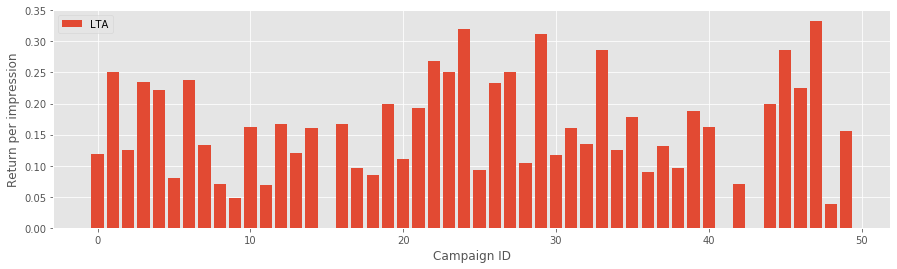

In [370]:
# Visualization of the attribution scores

campaign_idx = range(150,200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Linear Touch Attribution

In [459]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
def linear_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    def count_by_campaign2(df):
        counters = np.zeros(n_campaigns)
        for i,row in df.iterrows():
            campaign_id = np.argmax(row.loc["campaigns"])          
            counters[campaign_id] = counters[campaign_id] + row.loc['weight']
        return counters
    
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]

# For linear touch attribution - Weights should be assigned equally : 1/x
    df_converted['weight']=1/(df_converted['click_nb'])
    campaign_conversions = count_by_campaign2(df_converted)
    return campaign_conversions/campaign_impressions

    
lin = linear_attribution(df6)

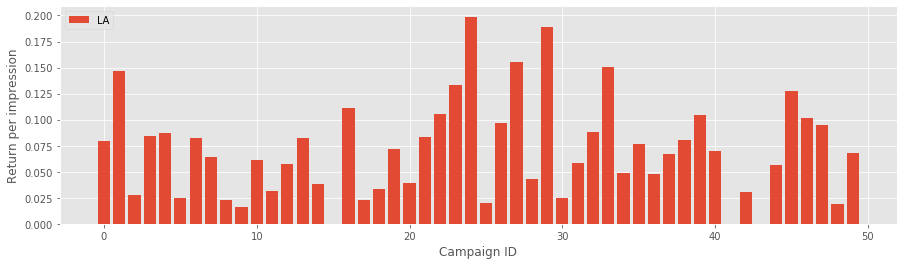

In [460]:
campaign_idx = range(150, 200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lin[campaign_idx])), lin[campaign_idx], label='LA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Time Decay Attribution

In [364]:
def timedecay_attribution(df):
    min_max_scaler=MinMaxScaler()    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters

#Function to get campaign impressions through adding weights to counters list
    def count_by_campaign2(df):
        counters = np.zeros(n_campaigns)
        for i,row in df.iterrows():
            campaign_id = np.argmax(row.loc["campaigns"])          
            counters[campaign_id] = counters[campaign_id] + row.loc["weight"]
        return counters
      
    campaign_impressions = count_by_campaign(df)
    df_converted = df[df['conversion'] == 1]
    df_converted["diff"]=df_converted['conversion_timestamp']-df_converted['timestamp']
    
# Scaling the time difference between conversion timestamp and touchpoint timestamps by min max scalar
    
    df_converted['scaleddiff']=min_max_scaler.fit_transform(df_converted[['diff']])
    

# Determining weights using exponential decaying function (e^-x), Less difference in timestamp : More weight 

    df_converted["weight"]=np.exp(-df_converted['scaleddiff'].astype(float))   
    campaign_conversions = count_by_campaign2(df_converted) 
    return campaign_conversions / campaign_impressions
    
    
td = timedecay_attribution(df6)
#td.sum()

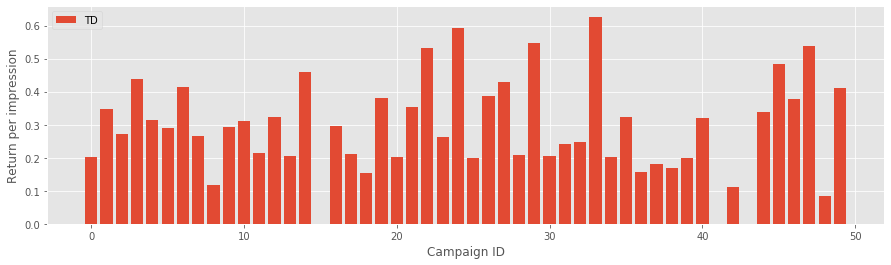

In [365]:
campaign_idx = range(150, 200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(td[campaign_idx])), td[campaign_idx], label='TD' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## First Touch Attribution

In [361]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
    
    return campaign_conversions / campaign_impressions
#     return campaign_conversions
fta = first_touch_attribution(df6)


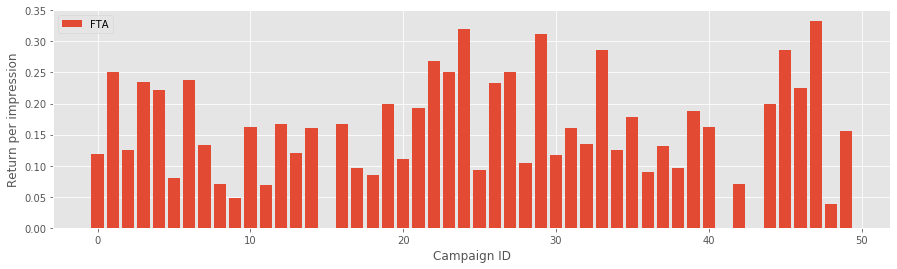

In [362]:
campaign_idx = range(150, 200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## U Shaped Attribution

In [359]:
def u_shaped_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    def assign_weights(pos,clicks):
        ext=0.4
        inter=0.2
        deff=0.5
        if clicks==2:
            return deff
        else:
            if pos==0 or pos==clicks-1 :
                return ext
            else :
                return inter/(clicks-2)


    def count_by_campaign2(df):
        counters = np.zeros(n_campaigns)
        for i,row in df.iterrows():
            campaign_id = np.argmax(row.loc["campaigns"])          
            counters[campaign_id] = counters[campaign_id] + row.loc["weight"]
        return counters
    
    campaign_impressions = count_by_campaign(df)
 
    df_converted = df[df['conversion'] == 1]
    df_converted['weight']=df_converted.apply(lambda x: assign_weights(x.click_pos,x.click_nb), axis=1)
   
    campaign_conversions = count_by_campaign2(df_converted)
    
    return campaign_conversions / campaign_impressions

ua = u_shaped_attribution(df6)


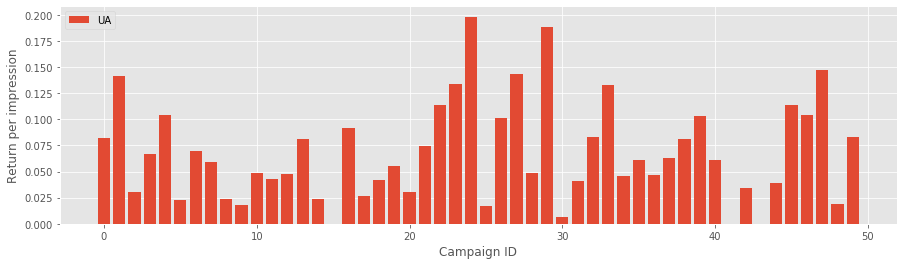

In [360]:
campaign_idx = range(150, 200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(ua[campaign_idx])), ua[campaign_idx], label='UA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## Logistic Regression

In [383]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [384]:
x, y = features_for_logistic_regression(df6)
print(np.shape(x))

(16989, 1362)


In [385]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [386]:
# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8393172454384933


In [387]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/10
85/85 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6655 - val_loss: 0.6291 - val_accuracy: 0.7503
Epoch 2/10
85/85 [==============================] - 0s 2ms/step - loss: 0.5981 - accuracy: 0.7740 - val_loss: 0.5841 - val_accuracy: 0.7723
Epoch 3/10
85/85 [==============================] - 0s 2ms/step - loss: 0.5574 - accuracy: 0.7872 - val_loss: 0.5537 - val_accuracy: 0.7738
Epoch 4/10
85/85 [==============================] - 0s 2ms/step - loss: 0.5289 - accuracy: 0.7873 - val_loss: 0.5323 - val_accuracy: 0.7738
Epoch 5/10
85/85 [==============================] - 0s 2ms/step - loss: 0.5082 - accuracy: 0.7907 - val_loss: 0.5175 - val_accuracy: 0.7753
Epoch 6/10
85/85 [==============================] - 0s 2ms/step - loss: 0.4931 - accuracy: 0.7939 - val_loss: 0.5068 - val_accuracy: 0.7819
Epoch 7/10
85/85 [==============================] - 0s 2ms/step - loss: 0.4816 - accuracy: 0.7991 - val_loss: 0.4986 - val_accuracy: 0.7830
Epoch 8/10
85/85 [==

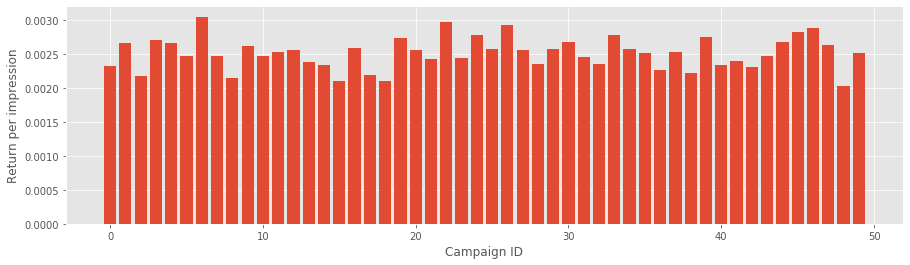

In [388]:
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

# Comparison of Multi Touch Attribution Models

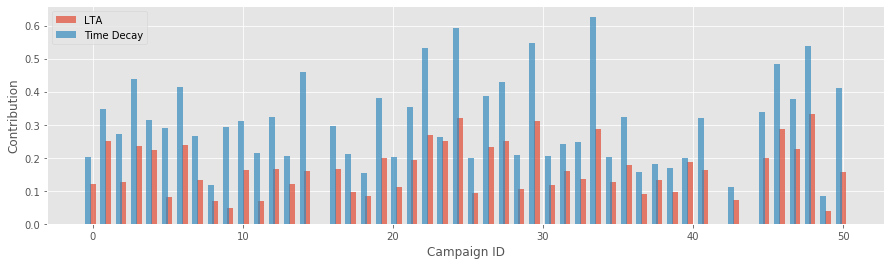

In [390]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
campaign_idx=range(150,200)
#ratio = max(lta[idx]) / max(la[idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, td[campaign_idx], width=0.4, alpha=0.7, label='Time Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

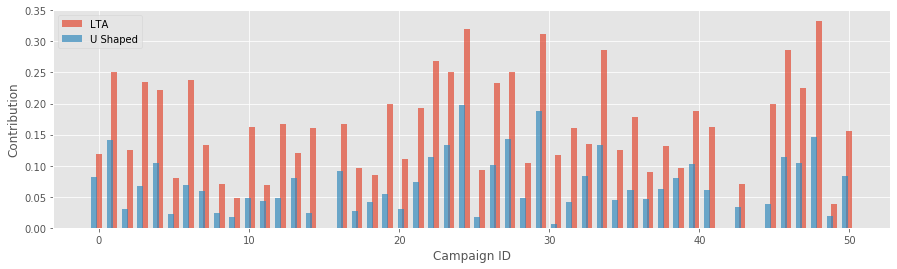

In [391]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
campaign_idx=range(150,200)
#ratio = max(lta[idx]) / max(la[idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, ua[campaign_idx], width=0.4, alpha=0.7, label='U Shaped' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

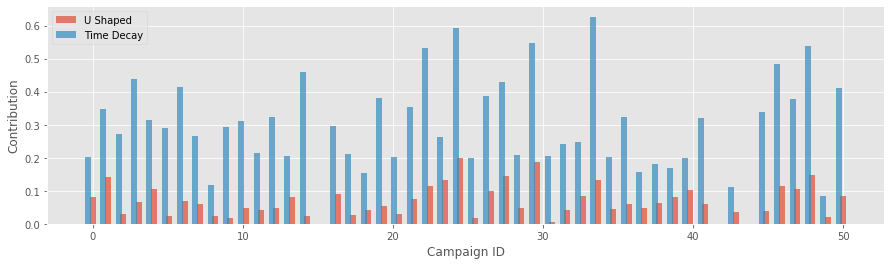

In [393]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
campaign_idx=range(150,200)
#ratio = max(lta[idx]) / max(la[idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), ua[campaign_idx], width=0.4, alpha=0.7, label='U Shaped' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, td[campaign_idx], width=0.4, alpha=0.7, label='Time Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

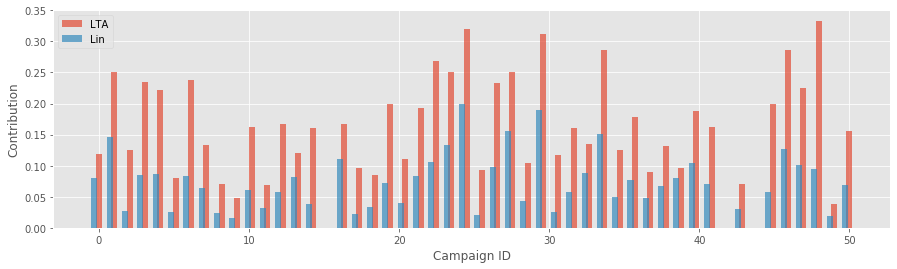

In [461]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
campaign_idx=range(150,200)
#ratio = max(lta[idx]) / max(la[idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, lin[campaign_idx], width=0.4, alpha=0.7, label='Lin' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

## Simulation of Return of Investment on the above models


In [462]:
# Removing NaN resulted due to 0 impressions and 0 conversions (due to sampled data) : 0/0

fta=fta[~np.isnan(fta)]
lta=lta[~np.isnan(lta)]
lin=lin[~np.isnan(lin)]
ua=ua[~np.isnan(ua)]
td=td[~np.isnan(td)]

In [402]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    #print(budgets)
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        #campaign_id=df.loc[i]['campaign']
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [403]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta, ua, td, keras_logreg]

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        print('{} {} : {}'.format(pitch, j, reward))

0.1 0 : 710
0.1 1 : 711
0.1 2 : 711
0.1 3 : 595
0.25 0 : 732
0.25 1 : 734
0.25 2 : 730
0.25 3 : 596
0.5 0 : 762
0.5 1 : 750
0.5 2 : 756
0.5 3 : 598
1.0 0 : 782
1.0 1 : 732
1.0 2 : 789
1.0 3 : 599
1.5 0 : 780
1.5 1 : 705
1.5 2 : 773
1.5 3 : 613
2.0 0 : 753
2.0 1 : 678
2.0 2 : 747
2.0 3 : 628
2.5 0 : 728
2.5 1 : 607
2.5 2 : 733
2.5 3 : 643
3.0 0 : 699
3.0 1 : 533
3.0 2 : 701
3.0 3 : 650


In [455]:
def ROI_model(attr):
    reward=[]
    for i, pitch in enumerate(pitches):
        reward.append(simulate_budget_roi(df6, 10000, attr**pitch))
    return reward


In [456]:
rlog=ROI_model(keras_logreg)
rushaped=ROI_model(ua)
rlta=ROI_model(lta)
rtd=ROI_model(td)

In [463]:
rlin=ROI_model(lin)

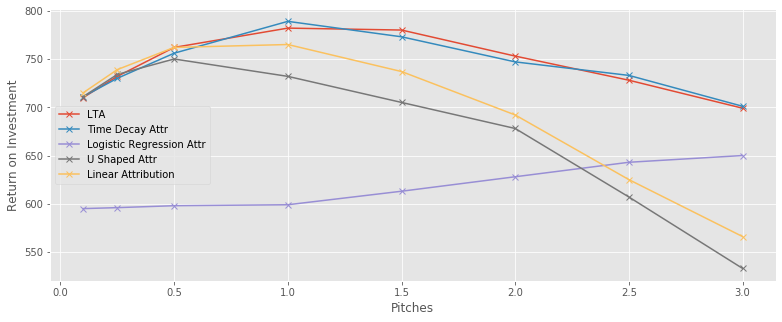

In [464]:
fig = plt.figure(figsize=(13, 5))
plt.plot(pitches,rlta,marker='x',label='LTA')
plt.plot(pitches,rtd,marker='x',label='Time Decay Attr')
plt.plot(pitches,rlog,marker='x',label='Logistic Regression Attr')
plt.plot(pitches,rushaped,marker='x',label='U Shaped Attr')
plt.plot(pitches,rlin,marker='x',label='Linear Attribution')
plt.xlabel('Pitches')
plt.ylabel('Return on Investment')
plt.legend()
plt.show()